In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from model import BertForSequenceClassification
from tqdm import tqdm

# Load tokenizer and model config
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
                    num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

# Load model and weights
model = BertForSequenceClassification(num_labels=2)
model.load_state_dict(torch.load("bert_model_finetuned.pth", map_location=torch.device('cpu')))
model.eval()

def preprocess(text, max_len):
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    tokens = tokenizer.tokenize(text if text else "None")
    tokens = tokens[:max_len]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    padded = token_ids + [0] * (max_len - len(token_ids))
    return torch.tensor(padded).unsqueeze(0)  # shape: (1, max_len)

# Load dataset
df = pd.read_csv("../../LIAR-PLUS-master/dataset/tsv/val2.tsv", sep='\t')

df.columns = [f"col{i}" for i in range(len(df.columns))]
df.columns = list(df.columns[:-1]) + ["justification"]

/Users/andrewzchen/.conda/envs/152_classifier/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [11]:
statement = "When Obama was sworn into office, he DID NOT use the Holy Bible, but instead the Kuran (Their equivalency to our Bible, but very different beliefs)."
justification = "Ellison used a Koran that once belonged to Thomas Jefferson, borrowing the rare book from the Library of Congress. It goes without saying that Ellison is not Obama. UPDATE:  Barack Obama  resigned from Trinity United Church of Christ  on May 31, 2008, after church pastor Jeremiah A.  Wright Jr.  made controversial remarks about U. S.  foreign policy and other matters."
metadata = "obama-birth-certificate,religion"
credit = 0.5

input_ids1 = preprocess(statement, max_len=64)
input_ids2 = preprocess(justification, max_len=256)
input_ids3 = preprocess(metadata, max_len=32)
credit_tensor = torch.tensor([credit] * 2304).unsqueeze(0)  # shape (1, 2304)

with torch.no_grad():
    logits = model(input_ids1, input_ids2, input_ids3, credit_tensor)
    probs = F.softmax(logits, dim=1)
    confidence = probs[0][1].item()
    prediction = "misinfo" if confidence > 0.5 else "not misinfo"

print(prediction, confidence)

not misinfo 0.06725400686264038


In [20]:
df_just = pd.read_csv("val2_preds_w_justification.csv")
df_wout_just = pd.read_csv("val2_preds_wout_justification.csv")
df_just_train = pd.read_csv("train2_preds_w_justification.csv")
df_wout_just_train = pd.read_csv("train2_preds_wout_justification.csv")

In [26]:
misinfo_labels = ["pants-fire", "false", "barely-true"]
not_misinfo_labels = ["half-true", "mostly-true", "true"]

def assign_label(row):
    if row["col2"] in misinfo_labels:
        return "misinfo"
    elif row["col2"] in not_misinfo_labels:
        return "not misinfo"
    else:
        return None

for df_name in ["df_just", "df_wout_just", "df_just_train", "df_wout_just_train"]:
    df_obj = globals()[df_name]
    df_obj["label"] = df_obj.apply(assign_label, axis=1)

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd

for df_name in ["df_just", "df_wout_just", "df_just_train", "df_wout_just_train"]:
    df_obj = globals()[df_name]
    print(f"Confusion matrix for {df_name}:")
    cm = confusion_matrix(df_obj["label"], df_obj["prediction"], labels=["misinfo", "not misinfo"])
    cm_df = pd.DataFrame(cm, index=["Actual misinfo", "Actual not misinfo"], columns=["Pred misinfo", "Pred not misinfo"])
    # Calculate precision, recall, and accuracy
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    tn = cm[1, 1]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    accuracy = (tp + tn) / cm.sum() if cm.sum() > 0 else 0.0
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(cm_df)
    print(cm)
    print()

Confusion matrix for df_just:
Precision: 0.7865, Recall: 0.1138, Accuracy: 0.5604
                    Pred misinfo  Pred not misinfo
Actual misinfo                70               545
Actual not misinfo            19               649
[[ 70 545]
 [ 19 649]]

Confusion matrix for df_wout_just:
Precision: 0.7250, Recall: 0.1886, Accuracy: 0.5768
                    Pred misinfo  Pred not misinfo
Actual misinfo               116               499
Actual not misinfo            44               624
[[116 499]
 [ 44 624]]

Confusion matrix for df_just_train:
Precision: 0.6849, Recall: 0.1168, Accuracy: 0.5990
                    Pred misinfo  Pred not misinfo
Actual misinfo                50               378
Actual not misinfo            23               549
[[ 50 378]
 [ 23 549]]

Confusion matrix for df_wout_just_train:
Precision: 0.6190, Recall: 0.1822, Accuracy: 0.6020
                    Pred misinfo  Pred not misinfo
Actual misinfo                78               350
Actual not misinf

Text(0.5, 1.0, 'With Justification')

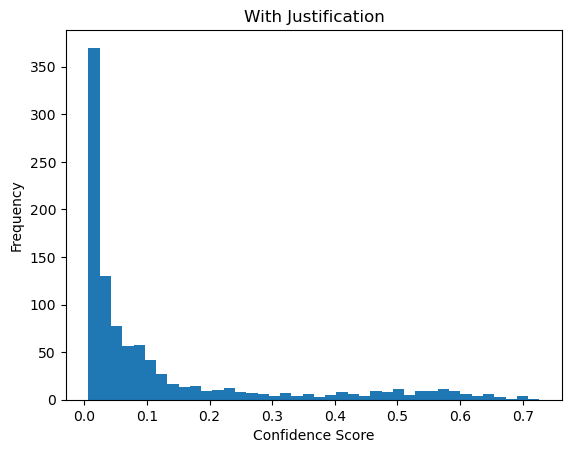

In [23]:
plt.hist(df_just_train["confidence_score"].astype(float), bins=40)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("With Justification")

Text(0.5, 1.0, 'Without Justification')

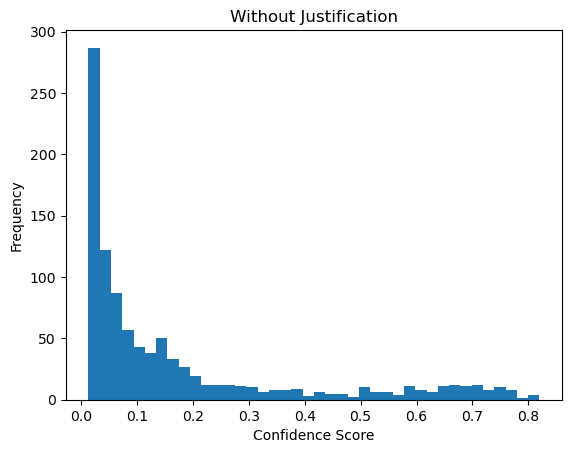

In [24]:
plt.hist(df_wout_just_train["confidence_score"].astype(float), bins=40)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Without Justification")

In [36]:
sorted(df_just[17].value_counts().keys())

['0.5144',
 '0.5178',
 '0.5199',
 '0.52',
 '0.5203',
 '0.5206',
 '0.5218',
 '0.522',
 '0.5226',
 '0.5229',
 '0.5232',
 '0.5235',
 '0.5238',
 '0.5243',
 '0.525',
 '0.5256',
 '0.5257',
 '0.5258',
 '0.5259',
 '0.5261',
 '0.5263',
 '0.5273',
 '0.5274',
 '0.5275',
 '0.5276',
 '0.5277',
 '0.5279',
 '0.5284',
 '0.5287',
 '0.529',
 '0.5294',
 '0.5295',
 '0.5296',
 '0.5297',
 '0.5298',
 '0.53',
 '0.5301',
 '0.5302',
 '0.5304',
 '0.5306',
 '0.5309',
 '0.531',
 '0.5311',
 '0.5312',
 '0.5314',
 '0.5315',
 '0.5316',
 '0.5317',
 '0.532',
 '0.5321',
 '0.5322',
 '0.5323',
 '0.5324',
 '0.5325',
 '0.5326',
 '0.5327',
 '0.5328',
 '0.5329',
 '0.5331',
 '0.5332',
 '0.5334',
 '0.5335',
 '0.5337',
 '0.5339',
 '0.534',
 '0.5343',
 '0.5345',
 '0.5346',
 '0.5347',
 '0.5348',
 '0.5349',
 '0.535',
 '0.5352',
 '0.5353',
 '0.5355',
 '0.5356',
 '0.5357',
 '0.5359',
 '0.536',
 '0.5361',
 '0.5362',
 '0.5363',
 '0.5364',
 '0.5365',
 '0.5366',
 '0.5367',
 '0.5368',
 '0.5369',
 '0.5371',
 '0.5372',
 '0.5373',
 '0.5374',


In [17]:
(169+248+251), (263 + 237 + 116)

(668, 616)